In [1]:
import logging

from dotenv import load_dotenv

logging.basicConfig(level=logging.ERROR)

# Load API keys
load_dotenv()

True

### Tools

In [2]:
import json
import inspect
import trafilatura

from rich.panel import Panel
from rich.console import Console
from rich.markdown import Markdown
from rich.json import JSON

from typing import Callable, Union

from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_tavily import TavilySearch, TavilyExtract
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI


from langchain.tools import tool



CUSTOM_DEBUG = True


def print_conversation(messages):
    console = Console(width=200, soft_wrap=True)

    for msg in messages:
        role = msg.get("role", "unknown").capitalize()

        content = msg.get("content", "")

        try:
            if isinstance(content, str):
                content = json.loads(content)

            elif isinstance(content, dict) and 'output' in content.keys():
                if isinstance(content['output'], HumanMessage):
                    content['output'] = content['output'].content

            elif isinstance(content, HumanMessage):
                content = content.content

            rendered_content = JSON.from_data(content)

        except (json.JSONDecodeError, TypeError):
            rendered_content = Markdown(content.strip())

        if role.lower() == "user":
            border_style_color = "green"
        elif role.lower() == "assistant":
            border_style_color = "magenta"
        else:
            border_style_color = "red"  # tools

        panel = Panel(
            rendered_content,
            title=f"[bold blue]{role}[/]",
            border_style=border_style_color,
            expand=True
        )

        console.print(panel)


def print_tool_call(tool: Callable, tool_name: str, args: dict):
    """Prints the tool call for debugging purposes."""
    sig = inspect.signature(tool)
    print_conversation(
        messages=[
            {
                'role': 'Tool-Call',
                'content': f"Calling `{tool_name}`{sig}"
            },
            {
                'role': 'Tool-Args',
                'content': args
            }
        ],
    )


def print_tool_response(response: Union[str, list]):
    """Prints the tool response for debugging purposes."""
    print_conversation(
        messages=[
            {
                'role': 'Tool-Response',
                'content': response
            }
        ],
    )


search_tool = TavilySearch(max_results=3)
extract_tool = TavilyExtract(extract_depth="advanced", format="markdown")


@tool
def local_competitor_search_and_extract(query: str, location: str = "") -> list[dict]:
    """
    Performs a geo-contextualized web search using the Tavily API for competitor insights,
    and returns structured content from top results.

    Example:
    - query = "footfall and peak hours of clothing stores"
    - location = "San Francisco, California"
    """

    MAX_NUMBER_OF_CHARS = 20_000

    full_query = f"{query} {location}".strip()

    if CUSTOM_DEBUG:
        print_tool_call(
            local_competitor_search_and_extract,
            tool_name='local_competitor_search_and_extract',
            args={'query': full_query, 'max_number_of_chars': MAX_NUMBER_OF_CHARS},
        )

    results = search_tool.invoke({"query": full_query})
    raw_results = results.get("results", [])
    urls = [r["url"] for r in raw_results if r.get("url")]

    if not urls:
        return [{"error": "No URLs found to extract from."}]

    extracted = extract_tool.invoke({"urls": urls})
    extracted_results = extracted.get("results", [])

    structured_results = []
    raw_contents = [doc.get("raw_content", "") for doc in extracted_results]

    for result, doc_content in zip(raw_results, raw_contents):
        doc_content_trunc = doc_content[:MAX_NUMBER_OF_CHARS]
        structured_results.append({
            "title": result.get("title"),
            "url": result.get("url"),
            "snippet": result.get("content"),
            "raw_content": doc_content_trunc,
            "source_type": "local_search",
            "location_context": location,
        })

    if CUSTOM_DEBUG:
        console_structured_results = [
            {k: v for k, v in r.items() if k != "raw_content"}
            for r in structured_results
        ]
        print_tool_response(json.dumps(console_structured_results))

    return structured_results


@tool
def search_and_extract_from_wikipedia(query: str) -> list:
    """Search Wikipedia for a query and extract useful information."""
    wiki_api_wrapper = WikipediaAPIWrapper()
    wiki_tool = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)
    if CUSTOM_DEBUG:
        print_tool_call(
            search_and_extract_from_wikipedia,
            tool_name='search_and_extract_from_wikipedia',
            args={'query': query},
        )
    response = wiki_tool.invoke(query)
    if CUSTOM_DEBUG:
        print_tool_response(response)
    return response


@tool
def aggregate_information(query: str, results: list[str]) -> str:
    """
    Processes a list of unstructured text chunks (e.g., search results) and produces a concise, query-specific summary.

    Each input text is filtered and summarized individually in the context of the provided query. Irrelevant results are discarded.
    Relevant content is aggregated and synthesized into a final, coherent answer that directly addresses the query.
    """
    if CUSTOM_DEBUG:
        print_tool_call(
            aggregate_information,
            tool_name='aggregate_information',
            args={'results': results, 'query': query},
        )
    if not results:
        response = "No search results provided."
        if CUSTOM_DEBUG:
            print_tool_response(response)
        return response

    # Convert to LangChain Document objects
    docs = [Document(page_content=chunk) for chunk in results]

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, max_retries=3)

    # 🔍 Map Prompt — Summarize each document in light of the query
    map_prompt = PromptTemplate.from_template(
        "You are assisting aggregating information from several soruces in the context of the research query: '{query}'.\n\n"
        "Search result:\n{text}\n\n"
        "Instructions:\n"
        "- If the result contains information relevant to the research query, summarize the relevant parts clearly. Separate in sections with titles when relevant\n"
        "- If the result is not helpful or unrelated, ignore it.\n"
        "- Do not include generic information or filler.\n"
        "- Focus on extracting facts, key statements, or numbers that directly support the research or related questions.\n\n"
        "Relevant Summary/Report:"
    )

    # 🧠 Combine Prompt — Aggregate the summaries to one final answer
    combine_prompt = PromptTemplate.from_template(
        "You are aggregating information to generate a report in Markdown format as the research output for the query: '{query}'.\n\n"
        "Here are the summaries/reports aggregations from filtered search results separated in sections:\n{text}\n\n"
        "Use the provided context to construct a report in Markdown format that directly supports and answer the research question.\n"
        "Context:"
    )

    chain = load_summarize_chain(
        llm,
        chain_type="map_reduce",
        map_prompt=map_prompt.partial(query=query),
        combine_prompt=combine_prompt.partial(query=query),
    )

    report = chain.invoke({'input_documents': docs})
    output_text = report.get('output_text', str(report))
    output_text = json.dumps({'report': output_text})

    if CUSTOM_DEBUG:
        print_tool_response(output_text)

    return output_text


@tool
def extract_clean_text_from_url(url: str) -> str:
    """Extract the main readable content from a webpage using trafilatura."""
    if CUSTOM_DEBUG:
        print_tool_call(
            extract_clean_text_from_url,
            tool_name='extract_clean_text_from_url',
            args={'url': url},
        )
    downloaded = trafilatura.fetch_url(url)
    response = ""
    if not downloaded:
        response = "Failed to download the page. Please check the URL."

    if not "Failed" in response:
        response = trafilatura.extract(downloaded)

    response = response or "No meaningful content found."
    if CUSTOM_DEBUG:
        print_tool_response(response)
    return response


@tool
def refine_query_with_user(raw_input: str) -> str:
    """
    Prompts the user for clarification in a Jupyter notebook setting.
    """
    user_message = f"""
    Let's refine your request so I can generate a precise report.\n\n
    Original Input: '{raw_input}'\n\n
    Please answer the following (default list):\n
          "- What specific location or area are you interested in?\n
          "- Are you looking for specific competitors or general trends in clothing stores?\n
          "- What kind of insights do you need? (e.g., peak hours, customer footfall, busiest days)\n
    """
    print_tool_response(user_message)
    user_response = input("Your clarified query: ")
    return user_response

In [3]:
import os
import requests



@tool
def get_geocode_with_nominatim(place_name: str):
    """Uses Nominatim to geocode a place name and return its 'latitude, longitude'"""
    if CUSTOM_DEBUG:
        print_tool_call(
            get_geocode_with_nominatim,
            tool_name='get_geocode_with_nominatim',
            args={'place_name': place_name},
        )
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": place_name,
        "format": "json",
        "limit": 1
    }
    response = requests.get(url, params=params, headers={"User-Agent": "LangGraph-Agent"})
    results = response.json()
    if results:
        location_info = {
            "lat": results[0]["lat"],
            "lon": results[0]["lon"],
            "display_name": results[0]["display_name"]
        }
    else:
        location_info = {"error": "No results found for the given place name."}
    if CUSTOM_DEBUG:
        print_tool_response(json.dumps(location_info))
    return location_info



@tool
def search_nearby_clothing_stores_by_latlon(lat_lon_location: str, radius_meters: int = 1000) -> list[dict]:
    """
    Uses Google Places API to find nearby clothing stores around the given location.
    Returns store names, addresses, and business data. The lat_lon_location must be in the format "latitude,longitude".
    """
    if CUSTOM_DEBUG:
        print_tool_call(
            search_nearby_clothing_stores_by_latlon,
            tool_name='search_nearby_clothing_stores_by_latlon',
            args={'location': lat_lon_location, 'radius_meters': radius_meters},
        )
    endpoint = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    params = {
        "key": os.getenv("GOOGLE_API_KEY"),
        "location": lat_lon_location,
        "radius": radius_meters,
        "type": "clothing_store"
    }

    response = requests.get(endpoint, params=params)
    data = response.json()
    with open("google_places_response.json", "w") as f:
        json.dump(data, f, indent=2)

    area_info = [
        {
            "name": place["name"],
            "address": place.get("vicinity"),
            "business_status": place.get("business_status", "Unknown"),
            "market": place.get("types", []),
            "rating": place.get("rating"),
            "user_ratings_total": place.get("user_ratings_total", 0),
            "opening_hours": place.get("opening_hours", {}),

        }
        for place in data.get("results", [])
    ]
    if CUSTOM_DEBUG:
        print_tool_response(area_info)
    return area_info

In [4]:
tools = [
    local_competitor_search_and_extract, 
    search_and_extract_from_wikipedia, 
    aggregate_information, 
    extract_clean_text_from_url, 
    refine_query_with_user,
    get_geocode_with_nominatim, 
    search_nearby_clothing_stores_by_latlon
]

for tool in tools:
    print(f"{tool.name}:\n{tool.description}\n{tool.args}\n")

local_competitor_search_and_extract:
Performs a geo-contextualized web search using the Tavily API for competitor insights,
and returns structured content from top results.

Example:
- query = "footfall and peak hours of clothing stores"
- location = "San Francisco, California"
{'query': {'title': 'Query', 'type': 'string'}, 'location': {'default': '', 'title': 'Location', 'type': 'string'}}

search_and_extract_from_wikipedia:
Search Wikipedia for a query and extract useful information.
{'query': {'title': 'Query', 'type': 'string'}}

aggregate_information:
Processes a list of unstructured text chunks (e.g., search results) and produces a concise, query-specific summary.

Each input text is filtered and summarized individually in the context of the provided query. Irrelevant results are discarded.
Relevant content is aggregated and synthesized into a final, coherent answer that directly addresses the query.
{'query': {'title': 'Query', 'type': 'string'}, 'results': {'items': {'type': '

### Agent

In [5]:
from langgraph.prebuilt import create_react_agent


llm = ChatOpenAI(model='gpt-4o', temperature=0, streaming=False, max_retries=3)

prompt = """
You are a business intelligence assistant specialized in competitive analysis of clothing stores in busy commercial areas. 
Your job is to provide concise and actionable insights on competitor footfall, peak customer hours, and market trends. 
Use the available tools to retrieve real-time data and generate useful reports for store owners, marketing teams, location analysts, and investors. 
Focus on helping users make data-driven decisions to improve their market position and strategy.
"""

react_agent = create_react_agent(
    model=llm,
    tools=tools,
    prompt=prompt,
    debug=False
)

conversation_messages = {
    "messages": [],
}

def chatbot(query: str):
    user_message = {'role': 'user', 'content': query}
    conversation_messages["messages"].append(user_message)
    print_conversation([user_message])
    response = react_agent.invoke(conversation_messages)

    final_answer = response['messages'][-1].content
    assistant_message = {'role': 'assistant', 'content': final_answer}
    conversation_messages["messages"].append(assistant_message)
    print_conversation([assistant_message])
    return assistant_message

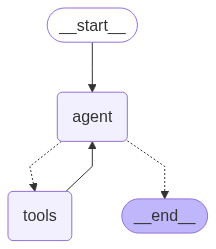

In [6]:
from IPython.display import Image

Image(react_agent.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0))

### Example 1: Specific Location-based search (LAT-LON)

In [7]:
query = "Summarize clothing store competitors and footfall patterns around Oxford Street, London"
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Summarize clothing store competitors and footfall patterns around Oxford Street, London                                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling local_competitor_search_and_extract(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "query": "clothing store competitors and footfall patterns Oxford Street, London",                                                                                                                 │
│   "max_number_of_chars": 20000                                                                                                                                                                       │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "title": "Oxford Street: Is it facing demise or resurgence? - BBC News",                                                                                                                         │
│     "url": "https://www.bbc.co.uk/news/uk-england-london-66533224",                                                                                                                                  │
│     "snippet": "Compared with last year, footfall on Oxford Street east is 30% up, 7% on the west side, mainly thanks to an increase in international visitors, New West End Company says.",         │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "Oxford Street, London"                                                                                                                                                      │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "Oxford Street 2030: What does evolution look like? - Colliers",                                                                                                                        │
│     "url": "https://www.colliers.com/en-gb/news/12-03-24-oxford-street-2030-report",                                                                                                                 │
│     "snippet": "Across five chapters, Oxford Street: 2030 examines the various drivers of Oxford's Street's transformation and outlines how it is leading the way in redefining what it means to be  │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "Oxford Street, London"                                                                                                                                                      │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "Ten years on Oxford Street: a decade of change on one of Britain's best ...",                                                                                                          │
│     "url": "https://localdatacompany.com/blog/ten-years-on-oxford-street",                                                                                                                           │
│     "snippet": "Looking back on the ten years of data we have on the GB retail and leisure market, we examine how Oxford Street has changed over a decade. Vacancy rates. Figure 1:

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling aggregate_information(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "results": [                                                                                                                                                                                       │
│     "Compared with last year, footfall on Oxford Street east is 30% up, 7% on the west side, mainly thanks to an increase in international visitors, New West End Company says.",                    │
│     "Across five chapters, Oxford Street: 2030 examines the various drivers of Oxford's Street's transformation and outlines how it is leading the way in redefining what it means to be a flagship  │
│     "Looking back on the ten years of data we have on the GB retail and leisure market, we examine how Oxford Street has changed over a decade. Vacancy rates. Figure 1: Oxford Street vacancy rate, │
│   ],                                                                                                                                                                                                 │
│   "query": "clothing store competitors and footfall patterns on Oxford Street, London"                                                                                                               │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "report": "```markdown\n# Report on Clothing Store Competitors and Footfall Patterns on Oxford Street, London\n\n## Footfall Patterns on Oxford Street\n\n- **Overall Increase**: Footfall on Oxfo │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here's a summary of the clothing store competitors and footfall patterns on Oxford Street, London:                                                                                                   │
│                                                                                                                                                                                                      │
│                                                                                          Footfall Patterns                                                                                           │
│                                                                                                                                                                                                      │
│  • Increase in Footfall: Footfall on Oxford Street east has increased by 30%, and by 7% on the west side, primarily due to more international visitors.                                              │
│  • Peak Times: The busiest times have shifted from weekdays to weekends, with Sundays seeing the highest footfall and spending.                                                                      │
│                                                                                                                                                                                                      │
│                                                                                        Retail Transformation                                                                                         │
│                                                                                                                                                                                                      │
│  • Oxford Street: 2030: The street is undergoing a transformation to become a flagship retail and leisure destination, driven by changes in consumer demand and a diverse retail mix.                │
│  • Retail Mix Evolution: There is a shift towards a broader range of retail and leisure experiences, which may impact footfall patterns and competition among clothing stores.                       │
│                                                                                                                                                                                                      │
│                                                                                         Competitor Insights                                                                                          │
│                                                                                                                                                                                                      │
│  • Vacancy Rates: Historically low vacancy rates have increased due to economic pressures, but the area remains desirable for its high footfall and visibility.                                      │
│  • Independent Growth: There has been a significant increase in independent businesses, particularly in cafés and takeaway food shops, which may influence the competitive landscape for clothing st │
│                                                                                                                                                                                                      │
│                                                                                   Implications for Clothing Stores                                                                                   │
│                                                                                                                                                                                    

In [8]:
query = "I need relevant information to open a clothing store in lat,lon= 51.3407317,12.371553"
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ I need relevant information to open a clothing store in lat,lon= 51.3407317,12.371553                                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling search_nearby_clothing_stores_by_latlon(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "location": "51.3407317,12.371553",                                                                                                                                                                │
│   "radius_meters": 1000                                                                                                                                                                              │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "name": "SportScheck Leipzig",                                                                                                                                                                   │
│     "address": "Hainstraße 21, Leipzig",                                                                                                                                                             │
│     "business_status": "OPERATIONAL",                                                                                                                                                                │
│     "market": [                                                                                                                                                                                      │
│       "shoe_store",                                                                                                                                                                                  │
│       "clothing_store",                                                                                                                                                                              │
│       "store",                                                                                                                                                                                       │
│       "point_of_interest",                                                                                                                                                                           │
│       "establishment"                                                                                                                                                                                │
│     ],                                                                                                                                                                                               │
│     "rating": 4.2,                                                                                                                                                                                   │
│     "user_ratings_total": 2248,                                                                                                                                                                      │
│     "opening_hours": {                                                                                                                                                                               │
│       "open_now": true                                                                                                                                                                               │
│     }                                                                                                                                                                                                │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here is a list of clothing store competitors around the location (51.3407317, 12.371553) in Leipzig:                                                                                                 │
│                                                                                                                                                                                                      │
│   1 SportScheck Leipzig                                                                                                                                                                              │
│      • Address: Hainstraße 21, Leipzig                                                                                                                                                               │
│      • Rating: 4.2 (2248 reviews)                                                                                                                                                                    │
│      • Market: Shoe and clothing store                                                                                                                                                               │
│   2 LUSH Cosmetics Leipzig                                                                                                                                                                           │
│      • Address: Petersstraße 39-41, Leipzig                                                                                                                                                          │
│      • Rating: 4.6 (778 reviews)                                                                                                                                                                     │
│      • Market: Clothing and home goods store                                                                                                                                                         │
│   3 tapir Leipzig - Ausrüstung für Rucksackreisende GmbH                                                                                                                                             │
│      • Address: Georgiring 4-7, Leipzig                                                                                                                                                              │
│      • Rating: 4.7 (599 reviews)                                                                                                                                                                     │
│      • Market: Shoe and clothing store                                                                                                                                                               │
│   4 H&M                                                                                                                                                                                              │
│      • Address: Brühl 1, Leipzig                                                                                                                                                                     │
│      • Rating: 3.8 (322 reviews)                                                                                                                                                                     │
│      • Market: Clothing store                                                                                                                                                                        │
│   5 Peek & Cloppenburg                                                                                                                                                             

### Example 2: General City/State wide search

In [9]:
query = "Generate a report on footfall and peak hours for clothing stores in San Francisco, California."
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Generate a report on footfall and peak hours for clothing stores in San Francisco, California.                                                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling local_competitor_search_and_extract(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "query": "footfall and peak hours of clothing stores San Francisco, California",                                                                                                                   │
│   "max_number_of_chars": 20000                                                                                                                                                                       │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "title": "San Francisco's Best Clothing Stores [Updated 2025]",                                                                                                                                  │
│     "url": "https://sanfransecrets.com/best-clothing-stores-in-san-francisco",                                                                                                                       │
│     "snippet": "San Francisco's Best Clothing Stores [Updated 2025] ... 🕒 Open Hours. Sunday: 11 AM-6 PM. Monday: 10 AM-7 PM. ... and hidden gems of San Francisco, California. With her keen eye f │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "San Francisco, California"                                                                                                                                                  │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "SF Citywear - San Francisco, CA - Yelp",                                                                                                                                               │
│     "url": "https://www.yelp.com/biz/sf-citywear-san-francisco",                                                                                                                                     │
│     "snippet": "Location & Hours. Suggest an edit. Located in: PIER 39. Pier 39. ... Clothing Stores. Dollar Store. Shopping. Sweaters. Souvenir Shops. Stores. ... BEST of San Francisco, CA 24 Hou │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "San Francisco, California"                                                                                                                                                  │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "The 48 coolest clothing stores and boutiques in San Francisco - Wanderlog",                                                                                                            │
│     "url": "https://wanderlog.com/list/geoCategory/123409/coolest-clothing-stores-and-boutiques-in-san-francisco",                                                                                   │
│     "snippet": "I will never travel to San Francisco without this app again Image 14: Get the Android app from Google Play Available on the App Store Download now Image 691Image 69

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling aggregate_information(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "results": [                                                                                                                                                                                       │
│     "San Francisco's Best Clothing Stores [Updated 2025] ... 🕒 Open Hours. Sunday: 11 AM-6 PM. Monday: 10 AM-7 PM. ... and hidden gems of San Francisco, California. With her keen eye for detail a │
│     "Published Time: 2025-02-02T00:00:00.000Z\n\nSan Francisco's Best Clothing Stores [Updated 2025]\n\n===============\n\n[Advertise Here on San Fran Secrets!](https://sanfransecrets.com/advertis │
│     "The 48 coolest clothing stores and boutiques in San Francisco - Wanderlog\n\nWrite a Review\n\nStart a Project\n\n# SF Citywear\n\n![Photo of SF Citywear - San Francisco, CA, US. Entrance of  │
│   ],                                                                                                                                                                                                 │
│   "query": "footfall and peak hours of clothing stores in San Francisco, California"                                                                                                                 │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "report": "# Footfall and Peak Hours of Clothing Stores in San Francisco, California\n\n## Overview\nThis report aggregates information on the operating hours and potential peak footfall times f │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here's a report on the footfall and peak hours of clothing stores in San Francisco, California:                                                                                                      │
│                                                                                                                                                                                                      │
│                                                                                               Overview                                                                                               │
│                                                                                                                                                                                                      │
│ This report provides insights into the operating hours and potential peak footfall times for various clothing stores in San Francisco. While specific footfall data is not available, the store hour │
│                                                                                                                                                                                                      │
│                                                                                         Store Hours Summary                                                                                          │
│                                                                                                                                                                                                      │
│ Below are the operating hours for selected clothing stores in San Francisco:                                                                                                                         │
│                                                                                                                                                                                                      │
│                                                                                           Urban Outfitters                                                                                           │
│                                                                                                                                                                                                      │
│  • Location: 80 Powell St, San Francisco, CA 94102                                                                                                                                                   │
│  • Open Hours:                                                                                                                                                                                       │
│     • Sunday: 11 AM–6 PM                                                                                                                                                                             │
│     • Monday to Thursday: 10 AM–7 PM                                                                                                                                                                 │
│     • Friday and Saturday: 10 AM–8 PM                                                                                                                                                                │
│                                                                                                                                                                                                      │
│                                                                                              Two Birds                                                                             

### Example 3: "Complex" use-cases

In [10]:
query = "What are the busiest hours and customer trends of clothing stores near SoHo, New York City?"
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ What are the busiest hours and customer trends of clothing stores near SoHo, New York City?                                                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling local_competitor_search_and_extract(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "query": "busiest hours and customer trends of clothing stores SoHo, New York City",                                                                                                               │
│   "max_number_of_chars": 20000                                                                                                                                                                       │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "title": "Shopping in SoHo NYC: The 25 Best Stores Right Now - Loving New York",                                                                                                                 │
│     "url": "https://loving-newyork.com/shopping-in-soho/",                                                                                                                                           │
│     "snippet": "The most common places to shop are 5th Avenue in Midtown and SoHo. Right after breakfast, you can make your way towards SoHo to check out the shopping scene. Also, top shops in New │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "SoHo, New York City"                                                                                                                                                        │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "Soho Shopping Guide: Independent Fashion in NYC - The Knickerbocker",                                                                                                                  │
│     "url": "https://www.theknickerbocker.com/soho-shopping-guide-independent-fashion-boutiques-to-fall-in-love-with/",                                                                               │
│     "snippet": "Discover (and Shop) More of New York City. Heading to NYC for some serious retail therapy? The Knickerbocker Hotel, located at the iconic intersection of 42nd Street and Broadway,  │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "SoHo, New York City"                                                                                                                                                        │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "Best Shopping in Soho - The Coolest Stores in NYC",                                                                                                                                    │
│     "url": "https://cornersofnewyork.co/soho-2/best-shopping-in-soho-the-coolest-stores-in-nyc/",                                                                                                    │
│     "snippet": "Welcome to Soho, one of New York City's most iconic and fashionable neighborhoods. From cobblestone streets to cast-iron buildings, this historic district is a tru

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling aggregate_information(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "results": [                                                                                                                                                                                       │
│     "The most common places to shop are 5th Avenue in Midtown and SoHo. Right after breakfast, you can make your way towards SoHo to check out the shopping scene. Also, top shops in New York City  │
│     "SoHo has had many lives. What started out as land farmed by Manhattan’s first free Black settlement during the colonial period evolved into a Revolutionary War defense locale, then a resident │
│     "Welcome to Soho, one of New York City's most iconic and fashionable neighborhoods. From cobblestone streets to cast-iron buildings, this historic district is a true shopping paradise and some │
│   ],                                                                                                                                                                                                 │
│   "query": "busiest hours and customer trends of clothing stores in SoHo, New York City"                                                                                                             │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "report": "```markdown\n# Report on Busiest Hours and Customer Trends of Clothing Stores in SoHo, New York City\n\n## Shopping Scene in SoHo\n\nSoHo is recognized as one of the most popular shop │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here's a report on the busiest hours and customer trends of clothing stores in SoHo, New York City:                                                                                                  │
│                                                                                                                                                                                                      │
│                                                                                        Shopping Scene in SoHo                                                                                        │
│                                                                                                                                                                                                      │
│ SoHo is recognized as one of the most popular shopping destinations in New York City, alongside 5th Avenue in Midtown. The area boasts a diverse range of stores, catering to various customer prefe │
│                                                                                                                                                                                                      │
│                                                                                            Store Variety                                                                                             │
│                                                                                                                                                                                                      │
│  • Affordable Brands: H&M, Zara, Uniqlo                                                                                                                                                              │
│  • High-End Brands: Off-White, Louis Vuitton                                                                                                                                                         │
│                                                                                                                                                                                                      │
│ This mix of affordable and luxury brands attracts a wide demographic of shoppers, contributing to the area's vibrant shopping atmosphere.                                                            │
│                                                                                                                                                                                                      │
│                                                                                           Customer Trends                                                                                            │
│                                                                                                                                                                                                      │
│                                                                                         Timing for Shopping                                                                                          │
│                                                                                                                                                                                                      │
│  • Peak Shopping Hours: It is suggested that shoppers tend to visit SoHo right after breakfast, indicating a potential peak in customer activity during late morning hours. This trend suggests that │
│                                                                                                                                                                                    

In [11]:
query = "How competitive is the clothing retail space near Indiranagar, Bangalore? What are typical peak hours?"
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ How competitive is the clothing retail space near Indiranagar, Bangalore? What are typical peak hours?                                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling local_competitor_search_and_extract(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "query": "clothing retail competition and peak hours Indiranagar, Bangalore",                                                                                                                      │
│   "max_number_of_chars": 20000                                                                                                                                                                       │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "title": "7 Boutiques In Indiranagar You Must Check Out - Medium",                                                                                                                               │
│     "url": "https://medium.com/trendarrow/7-boutiques-in-indiranagar-you-must-check-out-7a5b2b3e80a4",                                                                                               │
│     "snippet": "Where — 589,12th Main Road, Hal 2nd Stage, Indira Nagar Open hours — 10 AM to 6:30 PM Style factors — Well fitted evening wear and dresses for all occasions, lingerie and accessori │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "Indiranagar, Bangalore"                                                                                                                                                     │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "8 Best Malls & Clothing Stores in Indiranagar, Bangalore for Shopping",                                                                                                                │
│     "url": "https://uparhotels.com/blogs/8-best-malls-clothing-stores-for-shopping-in-indiranagar-bangalore",                                                                                        │
│     "snippet": "Book the best budget hotel in Indiranagar, Bangalore to find comfort and luxury at a price that doesn't break the bank. Best Malls in Indiranagar, Bangalore. Gopalan Mall Indiranag │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "Indiranagar, Bangalore"                                                                                                                                                     │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "6 BEST Shopping Malls Near Indiranagar, Bangalore [Must Visit]",                                                                                                                       │
│     "url": "https://knowyourbangalore.in/shopping-malls-near-indiranagar-bangalore/",                                                                                                                │
│     "snippet": "Address: 10/21, 2nd Stage, Binnamangala, Indiranagar, Bangalore, Karnataka 560038. Distance from Indiranagar: Approximately 3 km. Directions: By Car/Taxi: Head eas

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling aggregate_information(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "results": [                                                                                                                                                                                       │
│     "Where — 589,12th Main Road, Hal 2nd Stage, Indira Nagar Open hours — 10 AM to 6:30 PM Style factors — Well fitted evening wear and dresses for all occasions, lingerie and accessories",        │
│     "Book the best budget hotel in Indiranagar, Bangalore to find comfort and luxury at a price that doesn't break the bank. Best Malls in Indiranagar, Bangalore. Gopalan Mall Indiranagar, Bangalo │
│     "Address: 10/21, 2nd Stage, Binnamangala, Indiranagar, Bangalore, Karnataka 560038. Distance from Indiranagar: Approximately 3 km. Directions: By Car/Taxi: Head east on 100 Feet Road towards O │
│   ],                                                                                                                                                                                                 │
│   "query": "clothing retail competition and peak hours in Indiranagar, Bangalore"                                                                                                                    │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "report": "```markdown\n# Report on Clothing Retail Competition and Peak Hours in Indiranagar, Bangalore\n\n## Location\n- **Address**: 589, 12th Main Road, Hal 2nd Stage, Indira Nagar\n\n## Ope │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here's a report on the clothing retail competition and peak hours in Indiranagar, Bangalore:                                                                                                         │
│                                                                                                                                                                                                      │
│                                                                                               Location                                                                                               │
│                                                                                                                                                                                                      │
│  • Address: 589, 12th Main Road, Hal 2nd Stage, Indira Nagar                                                                                                                                         │
│                                                                                                                                                                                                      │
│                                                                                              Open Hours                                                                                              │
│                                                                                                                                                                                                      │
│  • Operating Hours: 10 AM to 6:30 PM                                                                                                                                                                 │
│                                                                                                                                                                                                      │
│                                                                                            Style Factors                                                                                             │
│                                                                                                                                                                                                      │
│  • Product Offering: The clothing retail sector in Indiranagar specializes in well-fitted evening wear, dresses for all occasions, lingerie, and accessories. This diverse product offering indicate │
│                                                                                                                                                                                                      │
│                                                                           Relevant Summary on Clothing Retail Competition                                                                            │
│                                                                                                                                                                                                      │
│  • Gopalan Mall Indiranagar: This mall serves as a significant retail hub in Indiranagar, contributing to the competitive dynamics of clothing retail in the area. The concentration of retail optio │
│                                                                                                                                                                                                      │
│                                                                                      Peak Hours in Indiranagar                                                                     

In [12]:
query = "What have we talked about so far? Make a short list with a description of the query and what you did to answer."
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ What have we talked about so far? Make a short list with a description of the query and what you did to answer.                                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here's a summary of our conversation so far, including the queries and how I addressed them:                                                                                                         │
│                                                                                                                                                                                                      │
│  1 Oxford Street, London - Competitor and Footfall Patterns:                                                                                                                                         │
│     • Query: Summarize clothing store competitors and footfall patterns around Oxford Street, London.                                                                                                │
│     • Response: Provided insights on footfall increases, peak shopping times, retail transformation, and competitor insights based on available data.                                                │
│  2 Leipzig, Germany - Clothing Store Competitors:                                                                                                                                                    │
│     • Query: Relevant information to open a clothing store in Leipzig (specific coordinates provided).                                                                                               │
│     • Response: Listed nearby clothing store competitors with their addresses and ratings to help assess the competitive landscape.                                                                  │
│  3 San Francisco, California - Footfall and Peak Hours:                                                                                                                                              │
│     • Query: Generate a report on footfall and peak hours for clothing stores in San Francisco, California.                                                                                          │
│     • Response: Provided a summary of store hours and general shopping trends to infer potential peak shopping times.                                                                                │
│  4 SoHo, New York City - Busiest Hours and Customer Trends:                                                                                                                                          │
│     • Query: Busiest hours and customer trends of clothing stores near SoHo, New York City.                                                                                                          │
│     • Response: Offered insights into peak shopping hours and customer trends based on the area's shopping scene and store variety.                                                                  │
│  5 Indiranagar, Bangalore - Retail Competition and Peak Hours:                                                                                                                                       │
│     • Query: Competitiveness of the clothing retail space near Indiranagar, Bangalore, and typical peak hours.                                                                                       │
│     • Response: Discussed the competitive landscape, presence of Gopalan Mall, and the need for further research on peak shopping hours.                                                             │
│                                                                                                                                                                                                      │
│ Each response was tailored to provide actionable insights based on the available data and tools.                                                                                   

### Example 4: Composite, Multi-hop query: (Investor & Expansion Strategist Use Case)

In [7]:
query = """
Suggest 3 high-footfall commercial neighborhoods in Berlin for opening a premium clothing store.
For each area, find top nearby clothing stores with their ratings, then summarize customer traffic trends, peak shopping hours, and any recent development or commercial changes in those areas. 
Finally, compile everything into a report comparing the neighborhoods for retail investment.
"""
chat_response = chatbot(query)

╭──────────────────────────────────────────────────────────────────────────────────────────────── User ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Suggest 3 high-footfall commercial neighborhoods in Berlin for opening a premium clothing store. For each area, find top nearby clothing stores with their ratings, then summarize customer traffic  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling search_and_extract_from_wikipedia(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "query": "high-footfall commercial neighborhoods in Berlin"                                                                                                                                        │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ Page: Brooklyn Bridge Summary: The Brooklyn Bridge is a cable-stayed suspension bridge in New York City, spanning the East River between the boroughs of Manhattan and Brooklyn. Opened on May 24, 1 │
│                                                                                                                                                                                                      │
│ Page: Waiting for Godot Summary: Waiting for Godot (  GOD-oh or   gə-DOH) is a 1953 play by Irish writer and playwright Samuel Beckett, in which the two main characters, Vladimir (Didi) and Estrag │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling local_competitor_search_and_extract(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "query": "high-footfall commercial neighborhoods in Berlin for retail Berlin, Germany",                                                                                                            │
│   "max_number_of_chars": 20000                                                                                                                                                                       │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "title": "Market data on multi-family houses and commercial properties in Berlin",                                                                                                               │
│     "url": "https://www.engelvoelkers.com/en-de/berlincommercial/market-reports-commercial-real-estate-berlin/",                                                                                     │
│     "snippet": "For the market report Germany, the real estate market was analyzed at 68 German locations. More. Report Berlin 19/20. ... Licence Partner Commercial Berlin Joachimsthaler Straße 1. │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "Berlin, Germany"                                                                                                                                                            │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "MarketBeats Germany | DE - Cushman & Wakefield",                                                                                                                                       │
│     "url": "https://www.cushmanwakefield.com/en/germany/insights/germany-marketbeat",                                                                                                                │
│     "snippet": "OFFICE, RETAIL, INDUSTRIAL, INVESTMENT, HOTEL and RESIDENTIAL — our MarketBeats, which appear every quarter, give you a complete overview of the current situation on the German rea │
│     "source_type": "local_search",                                                                                                                                                                   │
│     "location_context": "Berlin, Germany"                                                                                                                                                            │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "title": "Footfall Dashboard | BNP Paribas Real Estate",                                                                                                                                         │
│     "url": "https://www.realestate.bnpparibas.de/en/dashboards/footfall-dashboard",                                                                                                                  │
│     "snippet": "*   Offices *   Office market *   Office investment market Find out more about the **latest developments** in the **investment, office, logistics, retail, hotel, h

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling aggregate_information(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "results": [                                                                                                                                                                                       │
│     "Market data on multi-family houses and commercial properties in Berlin\n===============\n\nInterest-based processing of your data and its forwarding to third parties\n======================== │
│     "MarketBeats Germany | DE | Cushman & Wakefield\n\n===============\n\n[![Image 1: Cushman & Wakefield Logo](https://assets.cushmanwakefield.com/-/media/cw/global/about-us/logo.svg?rev=d52513d3 │
│     "Footfall Dashboard | BNP Paribas Real Estate\n\n===============\n\nReal estate for a changing world[de](https://www.realestate.bnpparibas.de/dashboards/footfall-dashboard) | [en](https://www. │
│   ],                                                                                                                                                                                                 │
│   "query": "high-footfall commercial neighborhoods in Berlin for retail"                                                                                                                             │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "report": "```markdown\n# High-Footfall Commercial Neighborhoods in Berlin for Retail\n\n## Market Overview\nThe Berlin commercial real estate market is characterized by a dynamic environment wi │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling get_geocode_with_nominatim(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling get_geocode_with_nominatim(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling get_geocode_with_nominatim(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "place_name": "Kreuzberg, Berlin, Germany"                                                                                                                                                         │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "place_name": "Mitte, Berlin, Germany"                                                                                                                                                             │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "place_name": "Friedrichshain, Berlin, Germany"                                                                                                                                                    │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "lat": "52.5122154",                                                                                                                                                                               │
│   "lon": "13.4502904",                                                                                                                                                                               │
│   "display_name": "Friedrichshain, Friedrichshain-Kreuzberg, Berlin, Deutschland"                                                                                                                    │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "lat": "52.5170120",                                                                                                                                                                               │
│   "lon": "13.3888222",                                                                                                                                                                               │
│   "display_name": "Mitte, Berlin, Deutschland"                                                                                                                                                       │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "lat": "52.4860843",                                                                                                                                                                               │
│   "lon": "13.3859508",                                                                                                                                                                               │
│   "display_name": "Platz der Luftbrücke, Mehringdamm, Kreuzberg, Friedrichshain-Kreuzberg, Berlin, 10965, Deutschland"                                                                               │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling search_nearby_clothing_stores_by_latlon(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling search_nearby_clothing_stores_by_latlon(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-call ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling search_nearby_clothing_stores_by_latlon(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str'                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "location": "52.4860843,13.3859508",                                                                                                                                                               │
│   "radius_meters": 1000                                                                                                                                                                              │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "location": "52.5170120,13.3888222",                                                                                                                                                               │
│   "radius_meters": 1000                                                                                                                                                                              │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────── Tool-args ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ {                                                                                                                                                                                                    │
│   "location": "52.5122154,13.4502904",                                                                                                                                                               │
│   "radius_meters": 1000                                                                                                                                                                              │
│ }                                                                                                                                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "name": "Jack Wolfskin Store",                                                                                                                                                                   │
│     "address": "Behrenstraße 23-24, Berlin",                                                                                                                                                         │
│     "business_status": "OPERATIONAL",                                                                                                                                                                │
│     "market": [                                                                                                                                                                                      │
│       "shoe_store",                                                                                                                                                                                  │
│       "clothing_store",                                                                                                                                                                              │
│       "store",                                                                                                                                                                                       │
│       "point_of_interest",                                                                                                                                                                           │
│       "establishment"                                                                                                                                                                                │
│     ],                                                                                                                                                                                               │
│     "rating": 4.6,                                                                                                                                                                                   │
│     "user_ratings_total": 188,                                                                                                                                                                       │
│     "opening_hours": {                                                                                                                                                                               │
│       "open_now": true                                                                                                                                                                               │
│     }                                                                                                                                                                                                │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "name": "HUMANA Secondhand & Vintage",                                                                                                                                                           │
│     "address": "Frankfurter Tor 3, Berlin",                                                                                                                                                          │
│     "business_status": "OPERATIONAL",                                                                                                                                                                │
│     "market": [                                                                                                                                                                                      │
│       "clothing_store",                                                                                                                                                                              │
│       "store",                                                                                                                                                                                       │
│       "point_of_interest",                                                                                                                                                                           │
│       "establishment"                                                                                                                                                                                │
│     ],                                                                                                                                                                                               │
│     "rating": 4,                                                                                                                                                                                     │
│     "user_ratings_total": 2646,                                                                                                                                                                      │
│     "opening_hours": {                                                                                                                                                                               │
│       "open_now": true                                                                                                                                                                               │
│     }                                                                                                                                                                                                │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "name": "Darkstore",                                                                                                                                                           

╭─────────────────────────────────────────────────────────────────────────────────────────── Tool-response ────────────────────────────────────────────────────────────────────────────────────────────╮
│ [                                                                                                                                                                                                    │
│   {                                                                                                                                                                                                  │
│     "name": "Blutsgeschwister Kleingeldgold",                                                                                                                                                        │
│     "address": "Kreuzbergstraße 31, Berlin-Bezirk Friedrichshain-Kreuzberg",                                                                                                                         │
│     "business_status": "OPERATIONAL",                                                                                                                                                                │
│     "market": [                                                                                                                                                                                      │
│       "clothing_store",                                                                                                                                                                              │
│       "store",                                                                                                                                                                                       │
│       "point_of_interest",                                                                                                                                                                           │
│       "establishment"                                                                                                                                                                                │
│     ],                                                                                                                                                                                               │
│     "rating": null,                                                                                                                                                                                  │
│     "user_ratings_total": 0,                                                                                                                                                                         │
│     "opening_hours": {}                                                                                                                                                                              │
│   },                                                                                                                                                                                                 │
│   {                                                                                                                                                                                                  │
│     "name": "PICKNWEIGHT - VINTAGE + SECONDHAND",                                                                                                                                                    │
│     "address": "Bergmannstraße 102/1. OG, Berlin",                                                                                                                                                   │
│     "business_status": "OPERATIONAL",                                                                                                                                              

╭───────────────────────────────────────────────────────────────────────────────────────────── Assistant ──────────────────────────────────────────────────────────────────────────────────────────────╮
│ Here's a detailed report comparing three high-footfall commercial neighborhoods in Berlin for opening a premium clothing store:                                                                      │
│                                                                                                                                                                                                      │
│                                                                                               1. Mitte                                                                                               │
│                                                                                                                                                                                                      │
│  • Top Clothing Stores:                                                                                                                                                                              │
│     • Jack Wolfskin Store: Rating 4.6, 188 reviews                                                                                                                                                   │
│     • BOSS Store: Rating 4.2, 194 reviews                                                                                                                                                            │
│     • AMPELMANN Shop Unter den Linden: Rating 4.4, 3665 reviews                                                                                                                                      │
│  • Customer Traffic Trends:                                                                                                                                                                          │
│     • Mitte is a central district with high pedestrian traffic, attracting both locals and tourists.                                                                                                 │
│     • The area is known for its cultural landmarks and shopping streets, making it a prime location for retail.                                                                                      │
│  • Peak Shopping Hours:                                                                                                                                                                              │
│     • Typically busy during weekends and late afternoons on weekdays.                                                                                                                                │
│  • Recent Developments:                                                                                                                                                                              │
│     • Continuous interest from international brands and investors due to its central location and tourist attractions.                                                                               │
│                                                                                                                                                                                                      │
│                                                                                             2. Kreuzberg                                                                                             │
│                                                                                                                                                                                                      │
│  • Top Clothing Stores:                                                                                                                                                            